**Obtención de series diarias del BCRP y análisis descriptivo**

Por: Garcia Caysahuana Gabriel

Actividades realizadas:
- Importación de librerias.
- Definición de funciones:
    - Deascarga de datos.
    - Procesamiento de datos.
    - Exploración de datos.
    - Comparación de Box Plot por año interactivo.
    - Serie temporal interactivo.
    - Gráfico interactivo de la Comparación de la media aritmetica mensual por año.
    - Grafica de distribución (Histograma de Frecuencia y densidad) y Gráfico de series temporales.
- Aplicación de funciones.

Nota: 
- Ingrese al siguiente link para ver el codigo de las series y el periodo de tiempo de disponibilidad: https://estadisticas.bcrp.gob.pe/estadisticas/series/diarias
- La obtención de las series se realiza mediante la API brindada por el BCRP.
- La data procesada se guarda (en formato csv) en la ruta de trabajo.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo 
import requests
from io import StringIO
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set()

In [3]:
def descargar_datos(url):
    response = requests.get(url)
    if response.status_code == 200:
        contenido_respuesta = response.text
        lineas = contenido_respuesta.split('<br>')
        return lineas
    else:
        print("La solicitud no fue exitosa. Código de estado:", response.status_code)
        return None

In [12]:
def procesar_datos(lineas):
    titulo = lineas.pop(0)
    titulo = titulo.split(',')[1]

    buffer = StringIO('\n'.join(lineas))
    df = pd.read_csv(buffer)
    df.columns = ['fecha', 'valor']

    df['valor'].replace('n.d.', np.nan, inplace=True)
    df['valor'] = df['valor'].astype(float)

    date = []
    for cadena in df['fecha']:
        if cadena[3:6] in ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dic']:
            cadena = cadena.replace('Ene', '01').replace('Feb', '02').replace('Mar', '03').replace('Abr', '04').replace('May', '05').replace('Jun', '06').replace('Jul', '07').replace('Ago', '08').replace('Set', '09').replace('Oct', '10').replace('Nov', '11').replace('Dic', '12')
            date.append(cadena)
        else:
            continue

    date = [datetime.strptime(d, '%d.%m.%y') for d in date]
    df['fecha'] = date

    df['fecha'] = pd.to_datetime(df['fecha'], format='%d.%b.%y')

    data = pd.DataFrame({
        'date': df['fecha'],
        'year': df['fecha'].dt.strftime('%Y'),
        'month': df['fecha'].dt.strftime('%B'),
        'value_month': df['fecha'].dt.strftime('%m'),
        'value_day_week': df['fecha'].dt.strftime('%u'),
        'value': df['valor'],
        'var': np.log(df['valor']/df['valor'].shift(1)),
        'null': df['valor'].isnull()
    })

    data = data.set_index('date')
    return data, titulo

In [54]:
def explorar_datos(data, titulo):
    #print('Número de valores perdidos:\n', data.isnull().sum())
    #print('\nNúmero de valores perdidos por año:\n', data.groupby('year')['null'].sum())
    #print('\nNumero de valores perdidos por mes:\n', data.groupby('month')['null'].sum())
    #print('\nNumero de valores perdidos por días de la semana:\n', data.groupby('value_day_week')['null'].sum())
    print(f'\nEstadísticos descriptivos del {titulo} por año:\n',data.groupby('year')['value'].describe().to_string())
    print('\nEstadísticos descriptivos de la variación diaria por año:\n',data.groupby('year')['var'].describe().to_string())


In [47]:
def visualizar_box_plot(data, titulo):
    data_sorted = data.sort_values(by='year')
    fig = px.box(data_sorted, y='value', color='year', title=titulo)
    fig.show()

In [48]:
def visualizar_line_plot(data, titulo):
    fig = px.line(data, y='value', labels={'value': '', 'fecha': 'Fecha'}, title=titulo)
    fig.show()

In [49]:
def visualizar_line_plot_var(data, titulo):
    fig = px.line(data, y='var', labels={'var': '', 'fecha': 'Fecha'}, title=f'Variación diaria del {titulo}')
    fig.show()

In [50]:
def visualizar_comparacion_anual(data):
    data_pivot = data.groupby(['value_month', 'year'])['value'].aggregate('mean').unstack()
    fig = px.line(data_pivot, x=data_pivot.index, y=data_pivot.columns,
                  title="Comparación del Comportamiento para Cada Año",
                  labels={'value_month': 'Mes', 'year': 'Año', 'value': 'Valor'},
                  markers=True, line_dash_sequence=["solid", "dot", "dash"])
    fig.show()

In [51]:
def visualizar_datos_combinados(data):
    fig, axes = plt.subplots(2, 2, figsize=(15, 6))

    # Histograma acumulativo
    sns.histplot(data['value'], edgecolor="white", cumulative=True, color='#1F618D', bins=20, ax=axes[0, 0])
    axes[0, 0].set_title('Histograma Acumulativo')

    # Histograma regular
    sns.histplot(data['value'], edgecolor="white", bins=20, ax=axes[0, 1])
    axes[0, 1].set_title('Histograma Regular')

    # Gráficos de series temporales en la segunda fila
    axes[1, 0].plot(data['value'], alpha=0.5, linestyle='-', label='input')
    axes[1, 0].plot(data['value'].resample('BA').mean(), linestyle=':', label='resample')
    axes[1, 0].plot(data['value'].asfreq('BA'), linestyle='--', label='asfreq')
    axes[1, 0].legend(loc='upper left')
    axes[1, 0].set_title('Series Temporales')

    fig.delaxes(axes[1, 1])

    plt.tight_layout()
    plt.show()


Estadísticos descriptivos del "Indicadores bursátiles - Índice General Bursátil BVL (índice)" por año:
       count          mean          std       min         25%        50%         75%       max
year                                                                                         
2010  249.0  16378.502691  2720.173129  13503.75  14366.7600  15105.990  18487.5800  23374.57
2011  260.0  20519.415731  1514.599031  17317.88  19366.4950  20099.350  21878.7325  23777.04
2012  261.0  21242.889272  1187.207040  19282.92  20260.8100  20887.630  22269.2700  24051.62
2013  261.0  17396.302682  2274.921178  14643.03  15556.4100  16444.540  19702.1500  21905.52
2014  261.0  15785.334215   865.049927  14032.78  15138.3000  15740.190  16636.9000  17248.57
2015  256.0  12034.175195  1480.958223   9641.45  10462.4550  12634.190  13290.0250  14794.32
2016  261.0  13522.125249  2096.812845   8878.15  11890.4300  13949.100  15301.4900  15784.29
2017  260.0  17160.422923  1571.935077  15054.77 

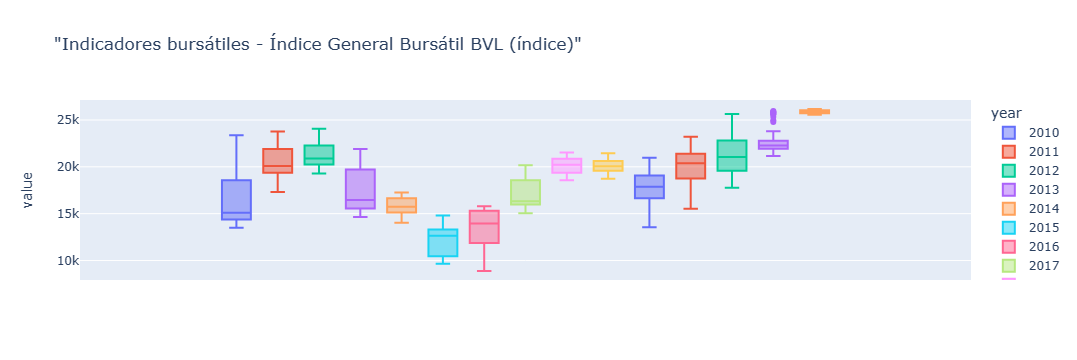

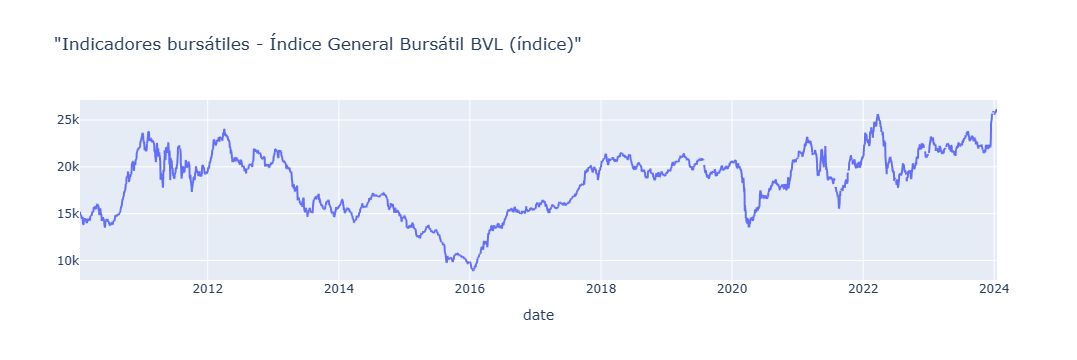

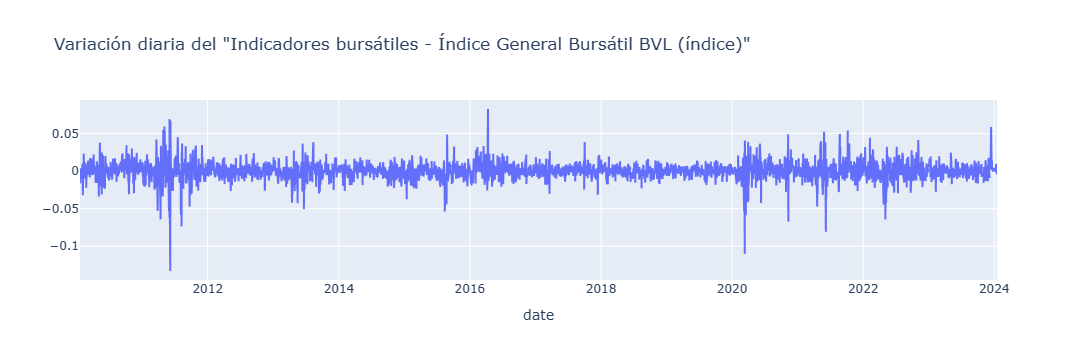

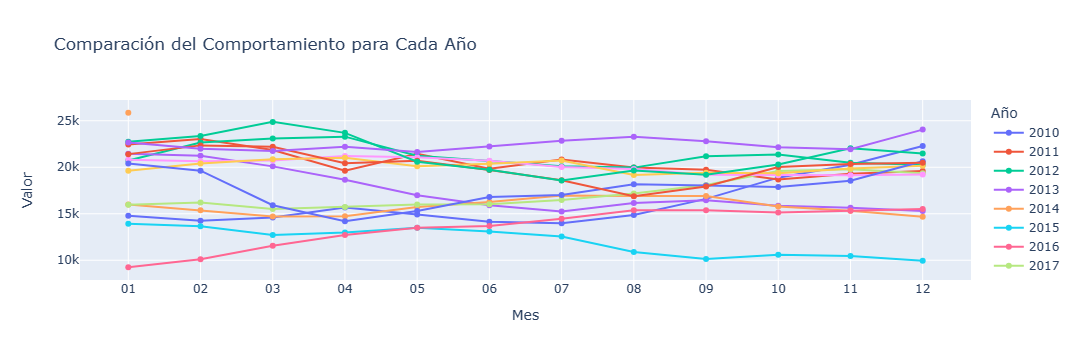

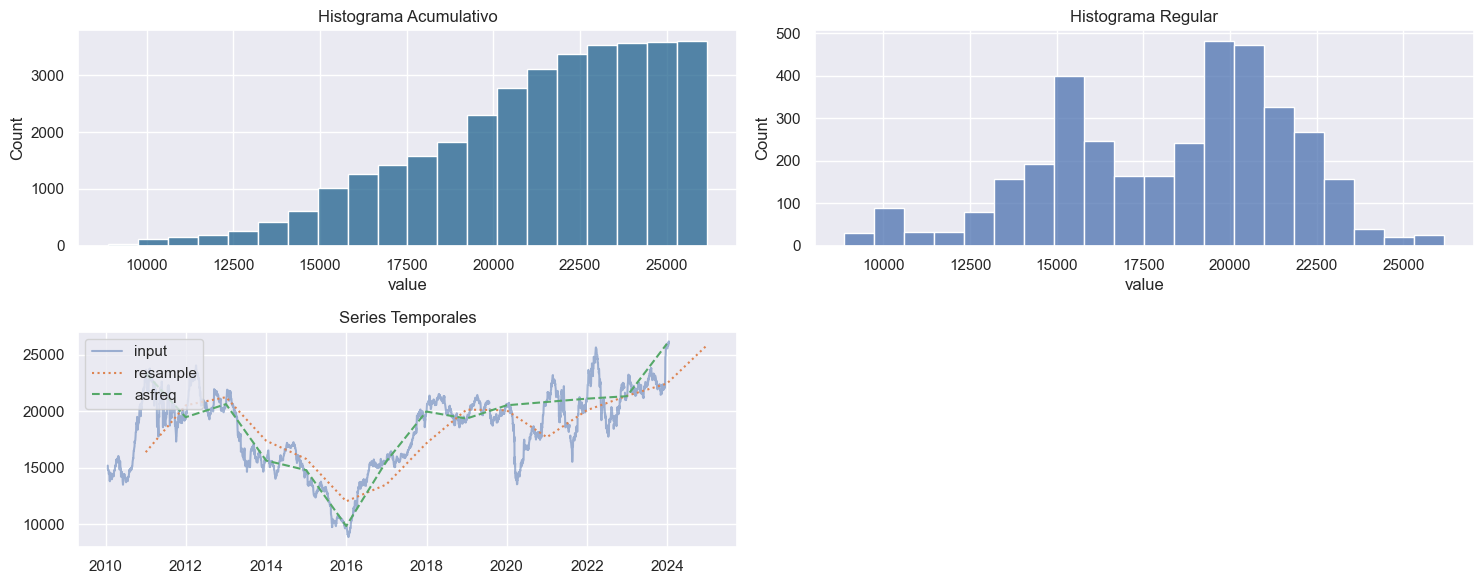

In [56]:
def main():
    url_base = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/api'
    codigos_series = 'PD38026MD'
    formato_salida = 'csv'
    #periodo_inicial = input("Ingrese la fecha de inicio (YYYY-M-D): ")
    periodo_inicial = '2010-01-17'
    #periodo_final = input("Ingrese la fecha de fin (YYYY-M-D): ")
    periodo_final = '2024-01-17'
    idioma = 'esp'

    url = f"{url_base}/{codigos_series}/{formato_salida}/{periodo_inicial}/{periodo_final}/{idioma}"

    lineas = descargar_datos(url)
    if lineas:
        data, titulo = procesar_datos(lineas)

        explorar_datos(data, titulo)
        visualizar_box_plot(data, titulo)
        visualizar_line_plot(data, titulo)
        visualizar_line_plot_var(data, titulo)
        visualizar_comparacion_anual(data)
        visualizar_datos_combinados(data)
        data.to_csv('data.csv', index = True)
if __name__ == "__main__":
    main()
